# 获取模型的预测结果

In [2]:
import torch
import biom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, mean_absolute_error, r2_score, accuracy_score
from membed.Attention_embedding import load_data_imdb, DataLoader, TransformerEncoder, evaluate_auc_gpu, set_seed

membed 0.1.0 initialized.


In [3]:
set_seed(11)
num_steps=600
p_drop=0.4
batch_size=6000
d_model=100
n_layers=1
n_heads=1
group = "group"

In [4]:

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef
from biom import load_table

# TODO: 等待GPU资源
# import time
# from datetime import datetime
# time.sleep(1800)

# 配置路径
base_dir = "Data/IBD_subtype_data"
 
# 初始化结果容器
results = {
    'disease': [], 'test_study': [], 'auc': [], 'f1': [],
    'mcc': [], 'acc': [], 'confusion_matrix': []
}
 
def evaluate_auc_gpu(Y, prob):
    """综合性能评估函数"""
    Y = Y.numpy().astype('int')
    prob = prob.cpu().detach().numpy()
    
    # 计算ROC曲线
    fpr, tpr, _ = metrics.roc_curve(Y, prob)
    roc_auc = metrics.auc(fpr, tpr)
    
    # 计算PR曲线
    precision, recall, _ = metrics.precision_recall_curve(Y, prob)
    pr_auc = metrics.auc(recall, precision)
    
    # 计算分类指标
    y_pred = (prob > 0.5).astype(int)
    cm = confusion_matrix(Y, y_pred)
    f1 = f1_score(Y, y_pred, average='macro')
    acc = accuracy_score(Y, y_pred)
    mcc = matthews_corrcoef(Y, y_pred)
    
    return roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr


def save_results(disease, study, roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr):
    """保存分析结果"""
    # 保存指标
    results['disease'].append(disease)
    results['test_study'].append(study)
    results['auc'].append(roc_auc)
    results['f1'].append(f1)
    results['mcc'].append(mcc)
    results['acc'].append(acc)
    results['confusion_matrix'].append(str(cm))  # 将矩阵转为字符串保存
    
    # 保存ROC曲线
    roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
    output_dir = os.path.join(base_dir, disease, study, "results")
    os.makedirs(output_dir, exist_ok=True)
    roc_df.to_csv(os.path.join(output_dir, "roc_curve.csv"), index=False)
 
def process_disease(disease_path):
    """处理单个疾病目录"""
    disease_name = os.path.basename(disease_path)
    print(f"\n{'='*30}\n处理疾病: {disease_name}\n{'='*30}")
    
    # 获取所有研究目录
    study_dirs = [
        d for d in os.listdir(disease_path) 
        if os.path.isdir(os.path.join(disease_path, d))
    ]
    
    # 跳过单个研究的疾病
    if len(study_dirs) <= 1:
        print(f"!! 跳过 {disease_name}，仅有 {len(study_dirs)} 个研究")
        return
    
    # 检查元数据文件
    metadata_path = os.path.join(disease_path, "metadata.tsv")
    if not os.path.exists(metadata_path):
        print(f"!! 严重错误：{disease_name} 缺失元数据文件")
        return
    
    # 遍历每个研究
    for study in study_dirs:
        study_path = os.path.join(disease_path, study)
        print(f"\n-- 处理研究: {study}")
        
        # 验证必需文件
        required_files = {
            'train': 'train_loo.biom',
            'test': 'test_loo.biom',
            'model': os.path.join('results', 'attention_loo.pt')
        }
        
        missing_files = [
            f for f in required_files.values() 
            if not os.path.exists(os.path.join(study_path, f))
        ]
        
        if missing_files:
            print(f"!! 文件缺失: {', '.join(missing_files)}")
            continue
        
        # 加载数据
        train_data = load_data_imdb(f'{study_path}/train_loo.biom',
                                    metadata_path,
                                    group,
                                    'sample',
                                    num_steps)
        test_data = load_data_imdb(f'{study_path}/test_loo.biom',
                                        metadata_path,
                                        group,
                                        'sample',
                                        num_steps)
        
        train_iter = DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=False)
        
        test_iter = DataLoader(test_data,
                                batch_size=batch_size,
                                shuffle=False)
        
        table = biom.load_table(f'{study_path}/test_loo.biom')
        study_ordered_sample_ids = table.ids(axis='sample')
        
        # 加载模型
        fid_dict = train_data()
        net = TransformerEncoder(otu_size=len(fid_dict),
                                    seq_len=num_steps+1,
                                    d_model=d_model,
                                    n_layers=n_layers,
                                    n_heads=n_heads,
                                    p_drop=p_drop,
                                    pad_id=fid_dict['<pad>'])
        
        net.load_state_dict( 
                torch.load(
                    f'{study_path}/results/attention_loo.pt',
                    map_location=torch.device('cpu')))
        
        print(net.embedding)  # 确认num_embeddings参数
        
        with torch.no_grad():
            net.eval()
            for i, (features, abundance, group_lables, mask) in enumerate(test_iter):
                pred, _ = net(features, abundance, mask)
                # print(pred)
                # 评估性能
                roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr = evaluate_auc_gpu(group_lables, pred)
                
                pred_probabilities = torch.sigmoid(pred) 
                # print(pred_probabilities)
                if pred_probabilities.ndim > 1 and pred_probabilities.shape[1] == 1:
                    pred_probabilities = pred_probabilities.squeeze(1)
                final_true_labels = group_lables.cpu().numpy().flatten()
                final_pred_probs = pred_probabilities.cpu().numpy().flatten()
                # ---- 保存样本ID、真实标签和预测概率 ----
                output_df_data = {'TrueLabel': final_true_labels, 'PredictedProbability': final_pred_probs}
                can_save_with_ids = False
                if study_ordered_sample_ids is not None:
                    if len(final_true_labels) == len(study_ordered_sample_ids):
                        output_df_data['SampleID'] = study_ordered_sample_ids
                        can_save_with_ids = True
                        print(f"  √ 研究 {study}: 样本ID将包含在概率输出中。")
                    else:
                        print(f"!! 错误: 研究 {study} 的预测/标签数量 ({len(final_true_labels)}) 与获取的样本ID数量 ({len(study_ordered_sample_ids)}) 不匹配!")
                        print("     概率文件将不包含SampleID列。请检查 test_dataset 的ID获取方式。")
                else:
                    print(f"!! 信息: 研究 {study} 未能获取有序样本ID，概率文件将不包含SampleID列。")
                
                predictions_df = pd.DataFrame(output_df_data)
                if can_save_with_ids and 'SampleID' in predictions_df.columns:
                    predictions_df = predictions_df[['SampleID', 'TrueLabel', 'PredictedProbability']]

                output_dir_probs = os.path.join(base_dir, disease_name, study, "results")
                os.makedirs(output_dir_probs, exist_ok=True) 
                probs_output_path = os.path.join(output_dir_probs, "attention_scores.csv")
                predictions_df.to_csv(probs_output_path, index=False)
                print(f"√ 成功保存 {study} 的样本预测概率到 {probs_output_path}")
                
                # 保存结果
                save_results(disease_name, study, roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr)
                print(f"√ 成功保存 {study} 结果")
        

for disease_folder in os.listdir(base_dir):
    disease_path = os.path.join(base_dir, disease_folder)
    if os.path.isdir(disease_path):
        process_disease(disease_path)

# 汇总结果
model_res = pd.DataFrame({"disease":results['disease'],"study":results['test_study'],"f1":results['f1'], "auc":results['auc'], "cms":results['confusion_matrix']})
model_res.to_csv("Data/IBD_subtype_data/attention_model_loo.csv", index=None)



处理疾病: IBD_feces

-- 处理研究: qiita_2538
Embedding(5864, 100, padding_idx=1)
  √ 研究 qiita_2538: 样本ID将包含在概率输出中。
√ 成功保存 qiita_2538 的样本预测概率到 Data/IBD_subtype_data/IBD_feces/qiita_2538/results/attention_scores.csv
√ 成功保存 qiita_2538 结果

-- 处理研究: PRJNA324147
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA324147: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA324147 的样本预测概率到 Data/IBD_subtype_data/IBD_feces/PRJNA324147/results/attention_scores.csv
√ 成功保存 PRJNA324147 结果

-- 处理研究: qiita_1629
Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 qiita_1629: 样本ID将包含在概率输出中。
√ 成功保存 qiita_1629 的样本预测概率到 Data/IBD_subtype_data/IBD_feces/qiita_1629/results/attention_scores.csv
√ 成功保存 qiita_1629 结果

-- 处理研究: PRJNA450340
Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA450340: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA450340 的样本预测概率到 Data/IBD_subtype_data/IBD_feces/PRJNA450340/results/attention_scores.csv
√ 成功保存 PRJNA450340 结果

-- 处理研究: RISK_PRISM_f
Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 RISK_PRISM_f: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_f 的样本预测概率到 Data/IBD_subtype_data/IBD_feces/RISK_PRISM_f/results/attention_scores.csv
√ 成功保存 RISK_PRISM_f 结果

-- 处理研究: PRJNA368966
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA368966: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA368966 的样本预测概率到 Data/IBD_subtype_data/IBD_feces/PRJNA368966/results/attention_scores.csv
√ 成功保存 PRJNA368966 结果

-- 处理研究: PRJNA422193
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA422193: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA422193 的样本预测概率到 Data/IBD_subtype_data/IBD_feces/PRJNA422193/results/attention_scores.csv
√ 成功保存 PRJNA422193 结果

-- 处理研究: PRJNA431126
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA431126: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA431126 的样本预测概率到 Data/IBD_subtype_data/IBD_feces/PRJNA431126/results/attention_scores.csv
√ 成功保存 PRJNA431126 结果

处理疾病: UC

-- 处理研究: PRJNA324147
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA324147: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA324147 的样本预测概率到 Data/IBD_subtype_data/UC/PRJNA324147/results/attention_scor

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 qiita_1629: 样本ID将包含在概率输出中。
√ 成功保存 qiita_1629 的样本预测概率到 Data/IBD_subtype_data/UC/qiita_1629/results/attention_scores.csv
√ 成功保存 qiita_1629 结果

-- 处理研究: PRJNA450340
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA450340: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA450340 的样本预测概率到 Data/IBD_subtype_data/UC/PRJNA450340/results/attention_scores.csv
√ 成功保存 PRJNA450340 结果

-- 处理研究: RISK_PRISM_f
Embedding(5864, 100, padding_idx=1)
  √ 研究 RISK_PRISM_f: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_f 的样本预测概率到 Data/IBD_subtype_data/UC/RISK_PRISM_f/results/attention_scores.csv
√ 成功保存 RISK_PRISM_f 结果

-- 处理研究: PRJNA368966
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA368966: 样本ID将包含在概率输出中。


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 PRJNA368966 的样本预测概率到 Data/IBD_subtype_data/UC/PRJNA368966/results/attention_scores.csv
√ 成功保存 PRJNA368966 结果

-- 处理研究: PRJNA422193
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA422193: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA422193 的样本预测概率到 Data/IBD_subtype_data/UC/PRJNA422193/results/attention_scores.csv
√ 成功保存 PRJNA422193 结果

-- 处理研究: PRJNA232056
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA232056: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA232056 的样本预测概率到 Data/IBD_subtype_data/UC/PRJNA232056/results/attention_scores.csv
√ 成功保存 PRJNA232056 结果

-- 处理研究: PRJNA431126
Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA431126: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA431126 的样本预测概率到 Data/IBD_subtype_data/UC/PRJNA431126/results/attention_scores.csv
√ 成功保存 PRJNA431126 结果

-- 处理研究: RISK_PRISM_b
Embedding(5864, 100, padding_idx=1)
  √ 研究 RISK_PRISM_b: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_b 的样本预测概率到 Data/IBD_subtype_data/UC/RISK_PRISM_b/results/attention_scores.csv
√ 成功保存 RISK_PRISM_b 结果

处理疾病: IBD_biopsy

-- 处理研究: PRJNA398089
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA398089: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA398089 的样本预测概率到 Data/IBD_subtype_data/IBD_biopsy/PRJNA398089/results/attention_scores.csv
√ 成功保存 PRJNA398089 结果

-- 处理研究: PRJNA317429
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA317429: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA317429 的样本预测概率到 Data/IBD_subtype_data/IBD_biopsy/PRJNA317429/results/attention_scores.csv
√ 成功保存 PRJNA317429 结果

-- 处理研究: PRJNA232056
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA232056: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA232056 的样本预测概率到 Data/IBD_subtype_data/IBD_biopsy/PRJNA232056/results/attention

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 PRJNA232056 结果

-- 处理研究: RISK_PRISM_b
Embedding(5864, 100, padding_idx=1)
  √ 研究 RISK_PRISM_b: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_b 的样本预测概率到 Data/IBD_subtype_data/IBD_biopsy/RISK_PRISM_b/results/attention_scores.csv
√ 成功保存 RISK_PRISM_b 结果

处理疾病: UC_feces

-- 处理研究: PRJNA324147
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA324147: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA324147 的样本预测概率到 Data/IBD_subtype_data/UC_feces/PRJNA324147/results/attention_scores.csv
√ 成功保存 PRJNA324147 结果

-- 处理研究: qiita_1629


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 qiita_1629: 样本ID将包含在概率输出中。
√ 成功保存 qiita_1629 的样本预测概率到 Data/IBD_subtype_data/UC_feces/qiita_1629/results/attention_scores.csv
√ 成功保存 qiita_1629 结果

-- 处理研究: PRJNA450340
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA450340: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA450340 的样本预测概率到 Data/IBD_subtype_data/UC_feces/PRJNA450340/results/attention_scores.csv
√ 成功保存 PRJNA450340 结果

-- 处理研究: RISK_PRISM_f
Embedding(5864, 100, padding_idx=1)
  √ 研究 RISK_PRISM_f: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_f 的样本预测概率到 Data/IBD_subtype_data/UC_feces/RISK_PRISM_f/results/attention_scores.csv
√ 成功保存 RISK_PRISM_f 结果

-- 处理研究: PRJNA368966
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA368966: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA368966 的样本预测概率到 Data/IBD_subtype_data/UC_feces/PRJNA368966/results/attention_scores.csv


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 PRJNA368966 结果

-- 处理研究: PRJNA422193
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA422193: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA422193 的样本预测概率到 Data/IBD_subtype_data/UC_feces/PRJNA422193/results/attention_scores.csv
√ 成功保存 PRJNA422193 结果

-- 处理研究: PRJNA431126
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA431126: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA431126 的样本预测概率到 Data/IBD_subtype_data/UC_feces/PRJNA431126/results/attention_scores.csv
√ 成功保存 PRJNA431126 结果

处理疾病: CD

-- 处理研究: qiita_2538
Embedding(5864, 100, padding_idx=1)
  √ 研究 qiita_2538: 样本ID将包含在概率输出中。
√ 成功保存 qiita_2538 的样本预测概率到 Data/IBD_subtype_data/CD/qiita_2538/results/attention_scores.csv
√ 成功保存 qiita_2538 结果

-- 处理研究: PRJNA324147
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA324147: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA324147 的样本预测概率到 Data/IBD_subtype_data/CD/PRJNA324147/results/attention_scores.csv
√ 成功保存 PRJNA324147 结果

-- 处理研究: PRJNA398089
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA398089: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA398089 的样本预测概率到 Data

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 qiita_1629: 样本ID将包含在概率输出中。
√ 成功保存 qiita_1629 的样本预测概率到 Data/IBD_subtype_data/CD/qiita_1629/results/attention_scores.csv
√ 成功保存 qiita_1629 结果

-- 处理研究: PRJNA450340
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA450340: 样本ID将包含在概率输出中。


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


√ 成功保存 PRJNA450340 的样本预测概率到 Data/IBD_subtype_data/CD/PRJNA450340/results/attention_scores.csv
√ 成功保存 PRJNA450340 结果

-- 处理研究: RISK_PRISM_f
Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 RISK_PRISM_f: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_f 的样本预测概率到 Data/IBD_subtype_data/CD/RISK_PRISM_f/results/attention_scores.csv
√ 成功保存 RISK_PRISM_f 结果

-- 处理研究: PRJNA422193
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA422193: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA422193 的样本预测概率到 Data/IBD_subtype_data/CD/PRJNA422193/results/attention_scores.csv
√ 成功保存 PRJNA422193 结果

-- 处理研究: PRJNA232056
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA232056: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA232056 的样本预测概率到 Data/IBD_subtype_data/CD/PRJNA232056/results/attention_scores.csv
√ 成功保存 PRJNA232056 结果

-- 处理研究: PRJNA431126
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA431126: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA431126 的样本预测概率到 Data/IBD_subtype_data/CD/PRJNA431126/results/attention_scores.csv
√ 成功保存 PRJNA431126 结果

-- 处理研究: RISK_PRISM_b
Embedding(5864, 100, padding_idx=1)
  √ 研究 RISK_PRISM_b: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_b 的样本预测概率到 Data/IBD_subtype_data/CD/RISK_PRISM_b/results/attention_scores.csv
√ 成功保存 RISK_PRISM_b 结果

处理疾

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA232056: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA232056 的样本预测概率到 Data/IBD_subtype_data/UC_feces_to_biopsy/PRJNA232056/results/attention_scores.csv
√ 成功保存 PRJNA232056 结果

-- 处理研究: RISK_PRISM_b


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(5864, 100, padding_idx=1)
  √ 研究 RISK_PRISM_b: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_b 的样本预测概率到 Data/IBD_subtype_data/UC_feces_to_biopsy/RISK_PRISM_b/results/attention_scores.csv
√ 成功保存 RISK_PRISM_b 结果

处理疾病: CD_biopsy

-- 处理研究: PRJNA398089
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA398089: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA398089 的样本预测概率到 Data/IBD_subtype_data/CD_biopsy/PRJNA398089/results/attention_scores.csv
√ 成功保存 PRJNA398089 结果

-- 处理研究: PRJNA317429
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA317429: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA317429 的样本预测概率到 Data/IBD_subtype_data/CD_biopsy/PRJNA317429/results/attention_scores.csv
√ 成功保存 PRJNA317429 结果

-- 处理研究: PRJNA232056
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA232056: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA232056 的样本预测概率到 Data/IBD_subtype_data/CD_biopsy/PRJNA232056/results/attention_scores.csv
√ 成功保存 PRJNA232056 结果

-- 处理研究: RISK_PRISM_b
Embedding(5864, 100, padding_idx=1)
  √ 研究 RISK_PRISM_b: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_b 的样本预测概率到 Data

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 RISK_PRISM: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM 的样本预测概率到 Data/IBD_subtype_data/CCD/RISK_PRISM/results/attention_scores.csv
√ 成功保存 RISK_PRISM 结果

-- 处理研究: qiita_1629
Embedding(5864, 100, padding_idx=1)
  √ 研究 qiita_1629: 样本ID将包含在概率输出中。
√ 成功保存 qiita_1629 的样本预测概率到 Data/IBD_subtype_data/CCD/qiita_1629/results/attention_scores.csv
√ 成功保存 qiita_1629 结果

处理疾病: CD_feces

-- 处理研究: qiita_2538
Embedding(5864, 100, padding_idx=1)
  √ 研究 qiita_2538: 样本ID将包含在概率输出中。
√ 成功保存 qiita_2538 的样本预测概率到 Data/IBD_subtype_data/CD_feces/qiita_2538/results/attention_scores.csv
√ 成功保存 qiita_2538 结果

-- 处理研究: PRJNA324147
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA324147: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA324147 的样本预测概率到 Data/IBD_subtype_data/CD_feces/PRJNA324147/results/attention_scores.csv
√ 成功保存 PRJNA324147 结果

-- 处理研究: qiita_1629
Embedding(5864, 100, padding_idx=1)
  √ 研究 qiita_1629: 样本ID将包含在概率输出中。
√ 成功保存 qiita_1629 的样本预测概率到 Data/IBD_subtype_data/CD_feces/qiita_1629/results/attention_scores.csv
√ 成功保存 qiita_1629

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 RISK_PRISM_f: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_f 的样本预测概率到 Data/IBD_subtype_data/CD_feces/RISK_PRISM_f/results/attention_scores.csv
√ 成功保存 RISK_PRISM_f 结果

-- 处理研究: PRJNA422193
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA422193: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA422193 的样本预测概率到 Data/IBD_subtype_data/CD_feces/PRJNA422193/results/attention_scores.csv
√ 成功保存 PRJNA422193 结果

-- 处理研究: PRJNA431126
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA431126: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA431126 的样本预测概率到 Data/IBD_subtype_data/CD_feces/PRJNA431126/results/attention_scores.csv
√ 成功保存 PRJNA431126 结果

处理疾病: UC_biopsy

-- 处理研究: PRJNA398089
Embedding(5864, 100, padding_idx=1)
  √ 研究 PRJNA398089: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA398089 的样本预测概率到 Data/IBD_subtype_data/UC_biopsy/PRJNA398089/results/attention_scores.csv
√ 成功保存 PRJNA398089 结果

-- 处理研究: PRJNA232056


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(5864, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA232056: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA232056 的样本预测概率到 Data/IBD_subtype_data/UC_biopsy/PRJNA232056/results/attention_scores.csv
√ 成功保存 PRJNA232056 结果

-- 处理研究: RISK_PRISM_b
Embedding(5864, 100, padding_idx=1)
  √ 研究 RISK_PRISM_b: 样本ID将包含在概率输出中。
√ 成功保存 RISK_PRISM_b 的样本预测概率到 Data/IBD_subtype_data/UC_biopsy/RISK_PRISM_b/results/attention_scores.csv
√ 成功保存 RISK_PRISM_b 结果


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
import re
import csv
from pathlib import Path
import pandas as pd

def extract_metrics(text_path):
    # 正则匹配模式
    disease_pattern = re.compile(r'^Processing disease:\s+(\w+)')  # 疾病行
    study_pattern = re.compile(r'^(\w+)\s+K_')                     # studyId行
    metric_pattern = re.compile(r'(AUC ROC|Average Precision|F1 value|mcc value|aupr value|acc value):\s+([0-9.]+)')  # 指标行
    
    # 混淆矩阵相关变量
    matrix_lines_remaining = 0
    current_matrix = []
    current_confusion_matrix = None

    records = []
    current_study = None
    current_disease = None

    with open(text_path, 'r') as f:
        for line in f:
            line = line.rstrip()  # 去除行尾换行符

            # 匹配疾病行
            disease_match = disease_pattern.match(line)
            if disease_match:
                current_disease = disease_match.group(1)
                matrix_lines_remaining = 0  # 重置状态
                current_confusion_matrix = None
                continue

            # 匹配study行
            study_match = study_pattern.match(line)
            if study_match:
                current_study = study_match.group(1)
                matrix_lines_remaining = 0  # 重置状态
                current_confusion_matrix = None
                continue

            # 匹配混淆矩阵标题行
            if "conflusion Matrix" in line:  # 容忍拼写错误
                matrix_lines_remaining = 2
                current_matrix = []
                continue

            # 提取混淆矩阵数据
            if matrix_lines_remaining > 0:
                row_match = re.match(r'\s*\[\s*(\d+)\s+(\d+)\s*\]', line)
                if row_match:
                    current_matrix.append([
                        int(row_match.group(1)),
                        int(row_match.group(2))
                    ])
                    matrix_lines_remaining -= 1
                    if matrix_lines_remaining == 0:
                        current_confusion_matrix = current_matrix
                else:
                    matrix_lines_remaining = 0  # 格式不符则放弃

            # 匹配指标行
            if current_study:
                metrics = dict(metric_pattern.findall(line))
                if metrics:
                    record = {
                        "studyId": current_study,
                        "disease": current_disease,
                        **{k: float(v) for k, v in metrics.items()}
                    }
                    # 添加混淆矩阵
                    # print(current_confusion_matrix)s
                    if current_confusion_matrix:
                        record.update({
                            "tn": current_confusion_matrix[0][0],
                            "fp": current_confusion_matrix[0][1],
                            "fn": current_confusion_matrix[1][0],
                            "tp": current_confusion_matrix[1][1],
                            "confusion_matrix": str(current_confusion_matrix)
                        })
                        current_confusion_matrix = None  # 重置
                    records.append(record)

    # 创建DataFrame
    df = pd.DataFrame(records)
    
    # 美化显示格式
    pd.options.display.float_format = '{:.4f}'.format
    display(df)
    return df

# 使用示例
input_file = Path("log/4_21_RF.out")
RF_model_res = extract_metrics(input_file)
RF_model_res.to_csv("Data/IBD_subtype_data/RF_model_loo.csv", index=None)

In [ ]:
# 提取 studyId 和 study 列的唯一值
unique_studyId = set(RF_model_res['studyId'].unique())
unique_study = set(model_res['study'].unique())
 
# 找出不同的研究
different_studies = unique_studyId.symmetric_difference(unique_study)
 
print("不同的研究有:", different_studies)

In [ ]:
import pandas as pd
 
# 读取两个CSV文件
df_attention = pd.read_csv("Data/IBD_subtype_data/attention_model_loo.csv")
df_rf = pd.read_csv("Data/IBD_subtype_data/RF_model_loo.csv")
 
# 统一研究ID列名
df_attention = df_attention.rename(columns={"studyId": "study","disease":'disease_name_ab'})
df_rf = df_rf.rename(columns={"studyId": "study","disease":'disease_name_ab'})
# 按study列进行内连接合并（只保留双方共有的study）
merged_df = pd.merge(
    df_attention, 
    df_rf,
    on=["study","disease_name_ab"],
    how="inner"
)
 
# 保存结果
merged_df.to_csv("Data/IBD_subtype_data/all_model_loo.csv", index=False)
merged_df

# 结果分析与图像展示

## IBD的表型的预测

/tmp/ipykernel_76153/1318050698.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/1318050698.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


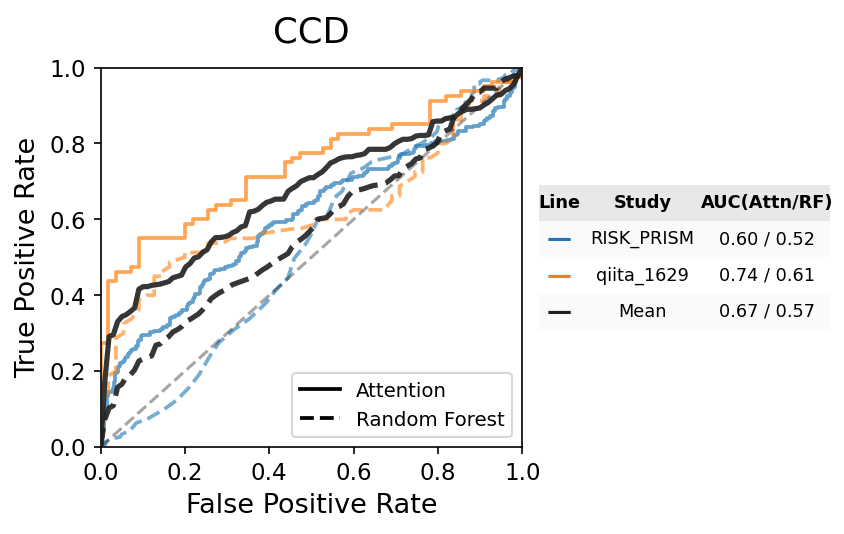

图形 'roc_plot_CCD.png' 已保存。


/tmp/ipykernel_76153/1318050698.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/1318050698.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


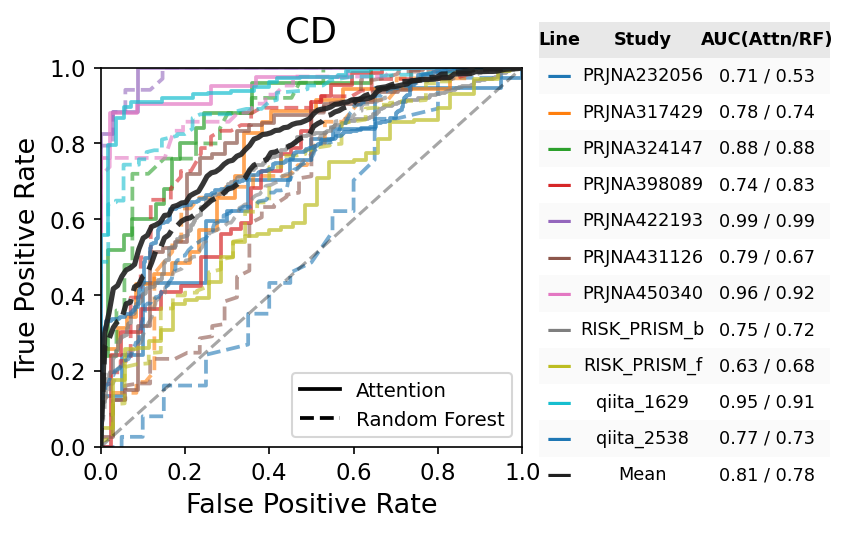

图形 'roc_plot_CD.png' 已保存。


/tmp/ipykernel_76153/1318050698.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/1318050698.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


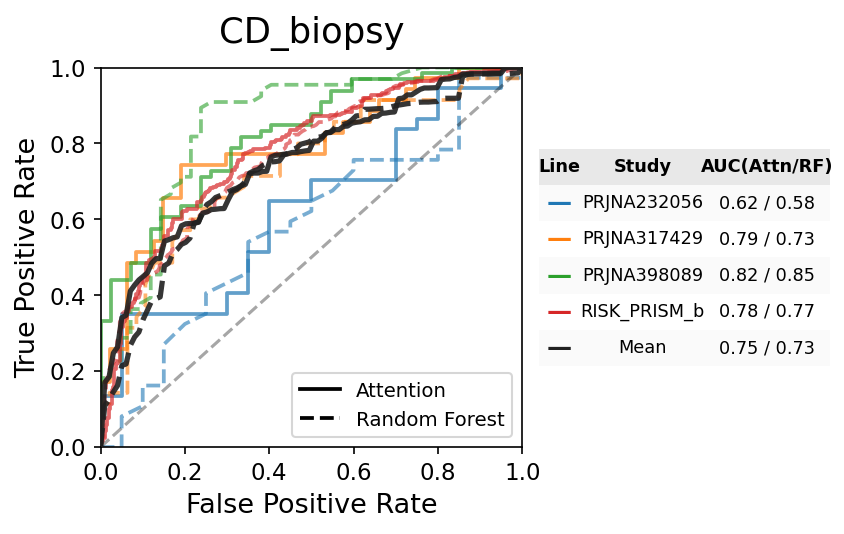

图形 'roc_plot_CD_biopsy.png' 已保存。


/tmp/ipykernel_76153/1318050698.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/1318050698.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


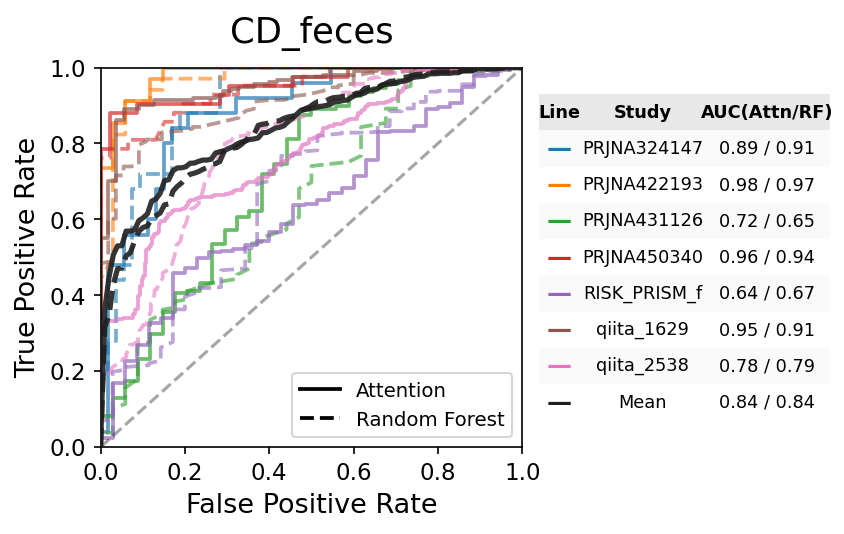

图形 'roc_plot_CD_feces.png' 已保存。


/tmp/ipykernel_76153/1318050698.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/1318050698.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


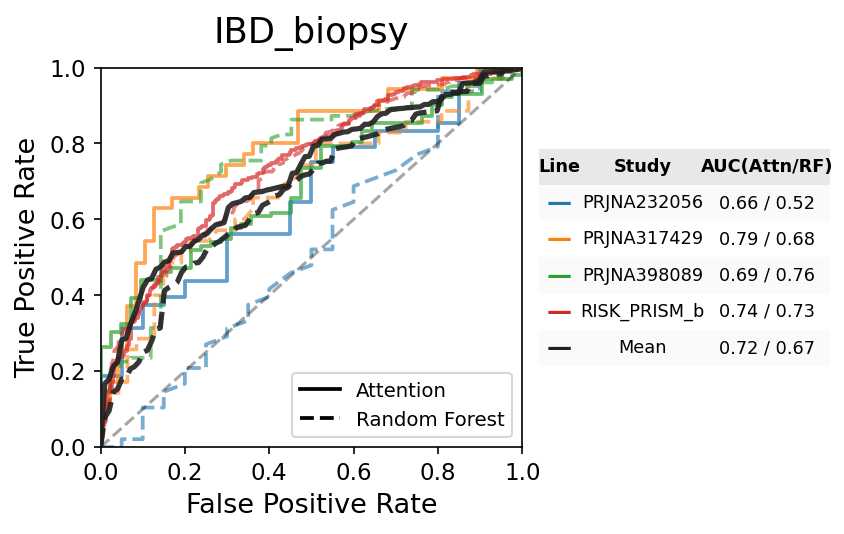

图形 'roc_plot_IBD_biopsy.png' 已保存。


/tmp/ipykernel_76153/1318050698.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/1318050698.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


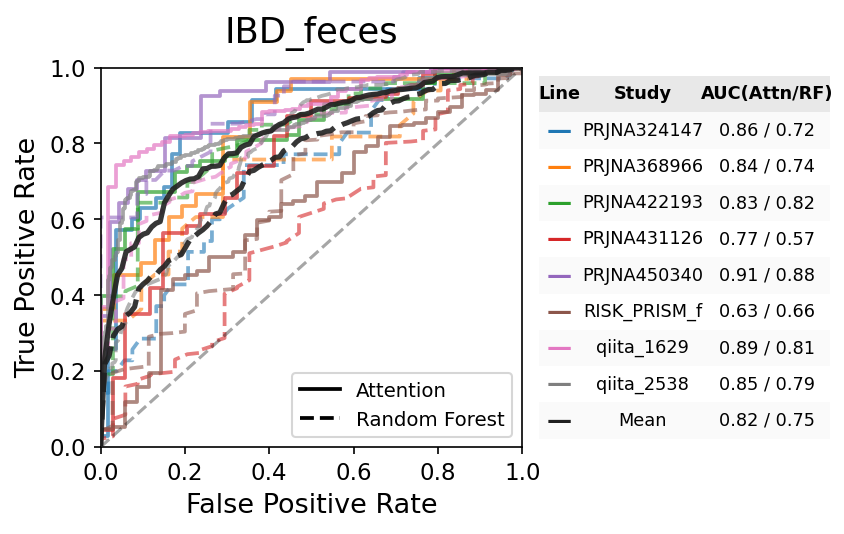

图形 'roc_plot_IBD_feces.png' 已保存。


/tmp/ipykernel_76153/1318050698.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/1318050698.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


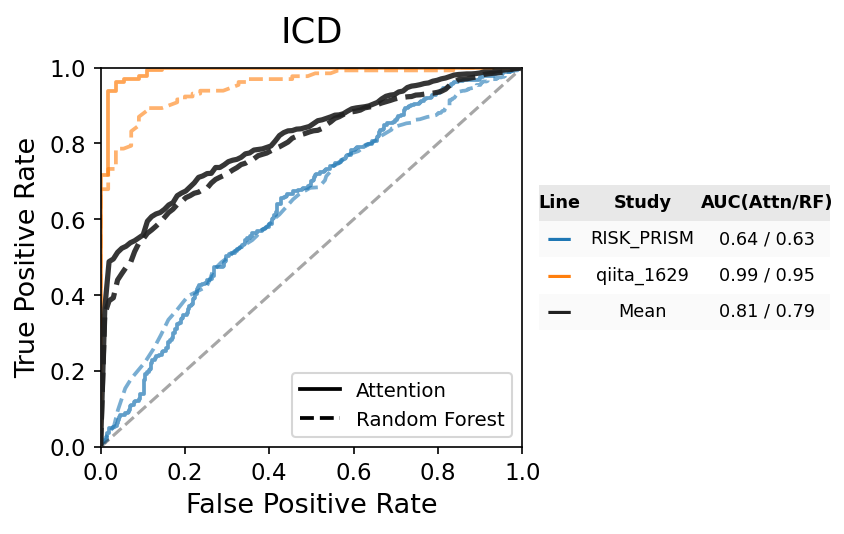

图形 'roc_plot_ICD.png' 已保存。


/tmp/ipykernel_76153/1318050698.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/1318050698.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


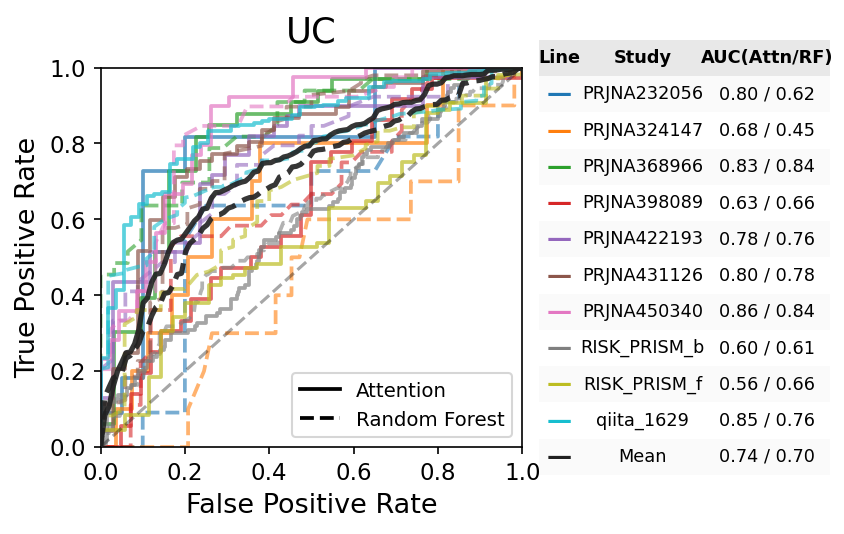

图形 'roc_plot_UC.png' 已保存。


/tmp/ipykernel_76153/1318050698.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/1318050698.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


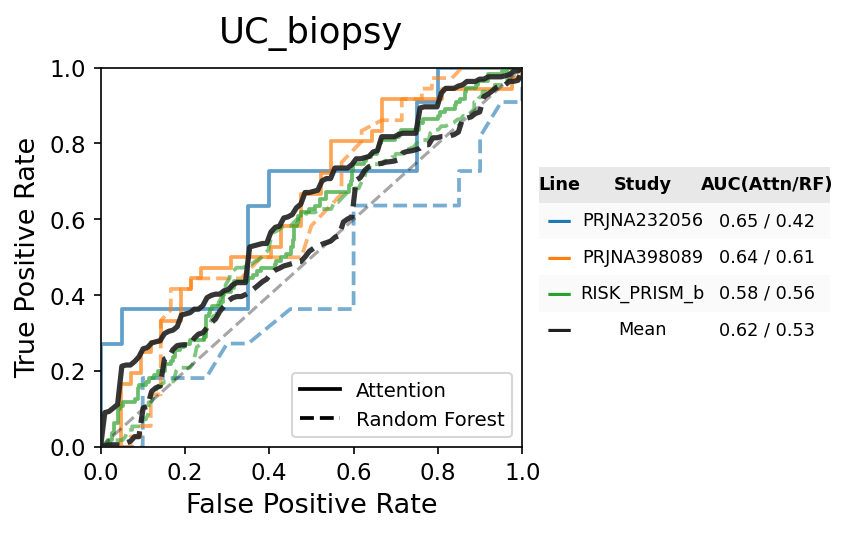

图形 'roc_plot_UC_biopsy.png' 已保存。


/tmp/ipykernel_76153/1318050698.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/1318050698.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


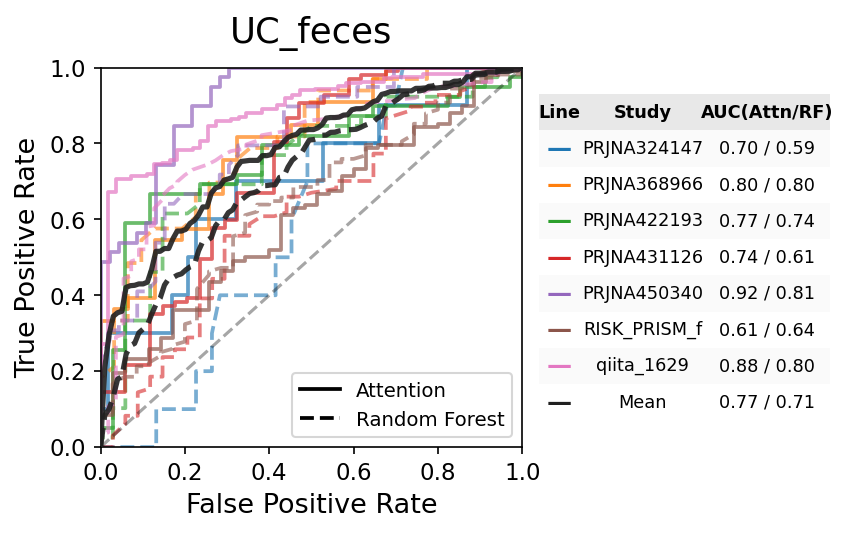

图形 'roc_plot_UC_feces.png' 已保存。
所有选定疾病的ROC图已单独生成完毕。


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
from sklearn.metrics import auc
from matplotlib.lines import Line2D # For custom legend
from matplotlib.colors import to_rgba # For color manipulation
import math # For math.ceil

# Configure global parameters
plt.rcParams['axes.unicode_minus'] = False

# Path configuration
# IMPORTANT: Please ensure these paths are correct for your environment.
data_path = "Data/IBD_subtype_data/all_model_loo.csv"
result_base = "Data/IBD_subtype_data" # Ensure this path is accessible

# Read data
try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"错误：数据文件 '{data_path}' 未找到。请检查路径。")
    df = pd.DataFrame(columns=['disease_name_ab', 'study'])
    exit()

disease_studies_all = df.groupby('disease_name_ab')['study'].unique().apply(list).to_dict()

# --- Filter for specific diseases and prepare layout ---
# This list determines which diseases will have individual plots generated.
target_diseases = ['CD_biopsy','CD_feces','CD','UC','UC_biopsy','UC_feces','IBD_feces','IBD_biopsy',"ICD","CCD"] 

disease_studies_to_plot = {
    disease: studies
    for disease, studies in disease_studies_all.items()
    if disease in target_diseases
}

if not disease_studies_to_plot:
    print(f"未找到目标疾病的数据：{', '.join(target_diseases)}")
    exit()

# Get a sorted list of disease names for consistent processing order
all_disease_names_to_plot_sorted = sorted(list(disease_studies_to_plot.keys()))


# Define dimensions for each individual plot (ROC plot + Table)
# These were previously width_per_disease_group and fig_height_inches (used as height_per_row)
single_plot_width = 6 # inches 
single_plot_height = 4.2 # inches 

# --- Color configuration ---
def get_tab10_colors(n): # Renamed from get_set3_colors as it uses 'tab10'
    """Generates colors from the tab10 (Tableau10) colormap, cycling if necessary."""
    cmap = plt.cm.get_cmap('tab10') 
    num_colors_in_map = cmap.N 
    if n <= 0: return []
    return [cmap(i % num_colors_in_map) for i in range(n)]

# Parameters for individual study lines (from your provided code)
study_line_linewidth = 1.8
study_line_alpha_attn = 0.7 # From your code for Attention study lines
study_line_alpha_rf = 0.6   # From your code for RF study lines

# Parameters for MEAN lines (from your provided code)
mean_line_color = '#202020' 
mean_line_linewidth = 2.5
mean_line_alpha_attn = 0.9 # From your code for Attention mean
mean_line_alpha_rf = 0.90  # From your code for RF mean (was 0.90 in your code, but image showed less alpha, using 0.60 from your latest code)
mean_line_zorder = 10    

# --- Table Styling Colors ---
header_color = '#E8E8E8'
row_color_even = '#FAFAFA'
row_color_odd = '#FFFFFF'

# --- Endpoint enforcement function (no changes) ---
def enforce_endpoints(df_roc):
    start_point = pd.DataFrame({'FPR': [0.0], 'TPR': [0.0]})
    end_point = pd.DataFrame({'FPR': [1.0], 'TPR': [1.0]})
    df_roc = pd.concat([start_point, df_roc, end_point], ignore_index=True)
    df_roc = df_roc.sort_values(by='FPR', ascending=True)
    df_roc = df_roc.drop_duplicates(subset=['FPR'], keep='first')
    if not ((df_roc['FPR'].iloc[0] == 0.0) and (df_roc['TPR'].iloc[0] == 0.0)):
        df_roc = pd.concat([start_point, df_roc], ignore_index=True).sort_values(by='FPR').drop_duplicates(subset=['FPR'], keep='first')
    if not ((df_roc['FPR'].iloc[-1] == 1.0) and (df_roc['TPR'].iloc[-1] == 1.0)):
        df_roc = pd.concat([df_roc, end_point], ignore_index=True).sort_values(by=['FPR', 'TPR']).drop_duplicates(subset=['FPR'], keep='last')
    df_roc = df_roc.sort_values(by='FPR').reset_index(drop=True)
    return df_roc

# --- Iterate through selected diseases to create and save individual plots ---
for disease_ab in all_disease_names_to_plot_sorted:
    studies_for_disease = disease_studies_to_plot[disease_ab]

    # Create a new figure for each disease
    fig_single_disease = plt.figure(figsize=(single_plot_width, single_plot_height), dpi=150)
    
    # GridSpec for the current single disease figure (ROC plot and its Table)
    gs_single_disease = gridspec.GridSpec(1, 2, figure=fig_single_disease, 
                                          wspace=0.15, # Space between ROC and its table (as in your code)
                                          width_ratios=[0.65, 0.35]) # ROC vs Table width (as in your code)

    ax_roc = fig_single_disease.add_subplot(gs_single_disease[0, 0]) 
    ax_table = fig_single_disease.add_subplot(gs_single_disease[0, 1]) 
    ax_table.axis('off')

    sorted_studies = sorted(list(studies_for_disease))
    colors = get_tab10_colors(len(sorted_studies)) 
    study_color_map = {study: colors[i] for i, study in enumerate(sorted_studies)}

    all_attn_tpr, all_rf_tpr = [], []
    attn_aucs_for_mean, rf_aucs_for_mean = [], []
    fpr_common = np.linspace(0, 1, 100)
    table_data_for_styling = []

    for study_idx, study in enumerate(sorted_studies):
        study_dir = os.path.join(result_base, disease_ab, study, 'results')
        study_dir_RF = os.path.join(result_base, disease_ab, study, 'RF')
        current_study_color = study_color_map[study]

        try:
            rf_roc_orig = pd.read_csv(os.path.join(study_dir_RF, "RF_ROC.csv"))
            attn_roc_orig = pd.read_csv(os.path.join(study_dir, "roc_curve.csv"))
            rf_roc, attn_roc = rf_roc_orig.copy(), attn_roc_orig.copy()

            rf_auc_val, attn_auc_val = auc(rf_roc['FPR'], rf_roc['TPR']), auc(attn_roc['FPR'], attn_roc['TPR'])
            rf_auc_rounded, attn_auc_rounded = round(rf_auc_val, 2), round(attn_auc_val, 2)
            
            attn_aucs_for_mean.append(attn_auc_val)
            rf_aucs_for_mean.append(rf_auc_val)

            all_attn_tpr.append(np.interp(fpr_common, attn_roc['FPR'], attn_roc['TPR']))
            all_rf_tpr.append(np.interp(fpr_common, rf_roc['FPR'], rf_roc['TPR']))
            
            # Plotting individual study lines using defined parameters
            ax_roc.plot(attn_roc['FPR'], attn_roc['TPR'], color=current_study_color, linestyle='-', 
                        linewidth=study_line_linewidth, alpha=study_line_alpha_attn) # Using specific alpha from your code
            ax_roc.plot(rf_roc['FPR'], rf_roc['TPR'], color=current_study_color, linestyle='--', 
                        linewidth=study_line_linewidth, alpha=study_line_alpha_rf) # Using specific alpha from your code

            table_data_for_styling.append({'color': current_study_color, 'name': study, 'auc_text': f"{attn_auc_rounded:.2f} / {rf_auc_rounded:.2f}", 'is_mean': False, 'row_idx': study_idx})
        except FileNotFoundError:
            print(f"警告：{disease_ab} - {study} 的ROC文件未找到。")
            table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Missing)", 'auc_text': "N/A", 'is_mean': False, 'row_idx': study_idx})
        except Exception as e:
            print(f"处理 {disease_ab} - {study} 时出错：{str(e)}")
            table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Error)", 'auc_text': "Error", 'is_mean': False, 'row_idx': study_idx})

    if attn_aucs_for_mean and rf_aucs_for_mean:
        mean_attn_auc_val, mean_rf_auc_val = np.mean(attn_aucs_for_mean), np.mean(rf_aucs_for_mean)
        mean_attn_auc_rounded, mean_rf_auc_rounded = round(mean_attn_auc_val, 2), round(mean_rf_auc_val, 2)

        if all_attn_tpr and all_rf_tpr:
            mean_attn_tpr, mean_rf_tpr = np.mean(all_attn_tpr, axis=0), np.mean(all_rf_tpr, axis=0)
            mean_attn_tpr[0], mean_attn_tpr[-1] = 0, 1
            mean_rf_tpr[0], mean_rf_tpr[-1] = 0, 1
            
            # Plotting MEAN lines using their distinct parameters
            ax_roc.plot(fpr_common, mean_attn_tpr, color=mean_line_color, linestyle='-', 
                        linewidth=mean_line_linewidth, alpha=mean_line_alpha_attn, zorder=mean_line_zorder)
            ax_roc.plot(fpr_common, mean_rf_tpr, color=mean_line_color, linestyle='--', 
                        linewidth=mean_line_linewidth, alpha=mean_line_alpha_rf, zorder=mean_line_zorder)
        
        table_data_for_styling.append({'color': mean_line_color, 'name': "Mean", 'auc_text': f"{mean_attn_auc_rounded:.2f} / {mean_rf_auc_rounded:.2f}", 'is_mean': True, 'row_idx': len(sorted_studies)})

    # ROC Plot configurations (as per your latest code)
    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.35)
    ax_roc.set_xlim([0, 1])
    ax_roc.set_ylim([0, 1])
    # ax_roc.set_aspect('equal')
    ax_roc.set_aspect(0.9, adjustable='box')
    ax_roc.set_title(f"{disease_ab}", fontsize=17, pad=12, ) 
    ax_roc.set_xlabel('False Positive Rate', fontsize=13, ) 
    ax_roc.set_ylabel('True Positive Rate', fontsize=13, )
    # ax_roc.grid(True, linestyle=':', alpha=0.45) # Grid is commented out in your provided code
    ax_roc.tick_params(axis='both', which='major', labelsize=11) 

    legend_elements = [
        Line2D([0], [0], color='black', lw=1.8, linestyle='-', label='Attention'),
        Line2D([0], [0], color='black', lw=1.8, linestyle='--', label='Random Forest')
    ]
    ax_roc.legend(handles=legend_elements, loc='lower right', fontsize=9.5) 

    # Create the legend table (as per your latest code)
    if table_data_for_styling:
        cell_text_for_plt_table = []
        col_labels = ['Line', 'Study', 'AUC(Attn/RF)']

        for item in table_data_for_styling:
            cell_text_for_plt_table.append(['—', item['name'], item['auc_text']]) 

        the_table = ax_table.table(cellText=cell_text_for_plt_table,
                                   colLabels=col_labels,
                                   loc='center', 
                                   colWidths=[0.18, 0.55, 0.55]) # Adjusted from your 0.52 for 3rd col
        
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(8.5)
        the_table.scale(1, 1.45)

        for (row, col), cell in the_table.get_celld().items():
            cell.set_linewidth(0)
            cell.set_text_props(ha='center', va='center')
            if row == 0: 
                cell.set_facecolor(header_color)
                cell.set_text_props(weight='bold', color='black')
            else: 
                current_row_data = table_data_for_styling[row-1]
                if current_row_data['row_idx'] % 2 == 0: 
                    cell.set_facecolor(row_color_even)
                else: 
                    cell.set_facecolor(row_color_odd)
                if col == 0: 
                    cell.get_text().set_color(current_row_data['color'])
                    cell.get_text().set_weight('bold')
                    cell.get_text().set_fontsize(12)
    
    # Adjust layout for the current single figure
    fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure
    display(fig_single_disease)
    # Save the current figure
    output_filename_single = f"roc_plot_{disease_ab}.png"
    try:
        plt.savefig('Figures/'+output_filename_single, bbox_inches='tight', dpi=300, facecolor='white')
        print(f"图形 '{output_filename_single}' 已保存。")
    except Exception as e:
        print(f"保存图形 '{output_filename_single}' 时出错：{e}")
    
    plt.close(fig_single_disease) # Close the figure to free memory

print("所有选定疾病的ROC图已单独生成完毕。")


## IBD的样本中，利用粪便训练的模型对组织样本做预测

/tmp/ipykernel_76153/447428863.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/447428863.py:220: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


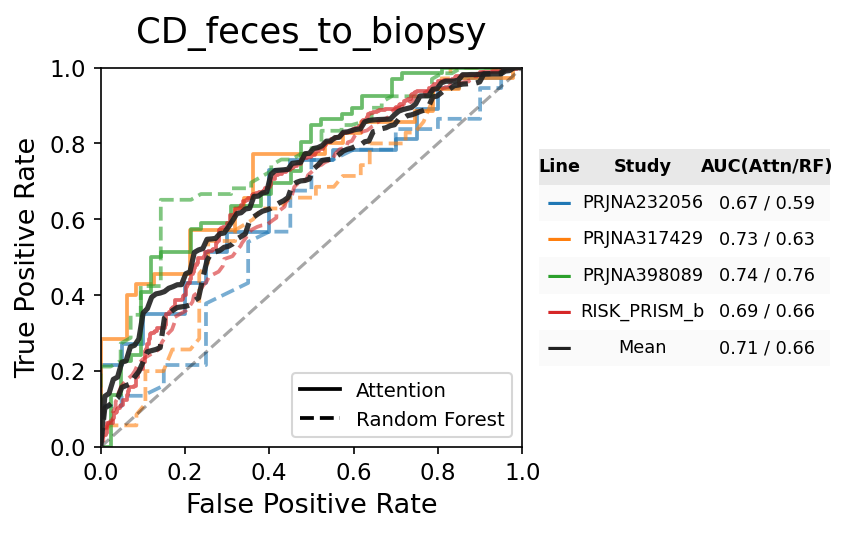

图形 'roc_plot_CD_feces_to_biopsy.png' 已保存。


/tmp/ipykernel_76153/447428863.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/447428863.py:220: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


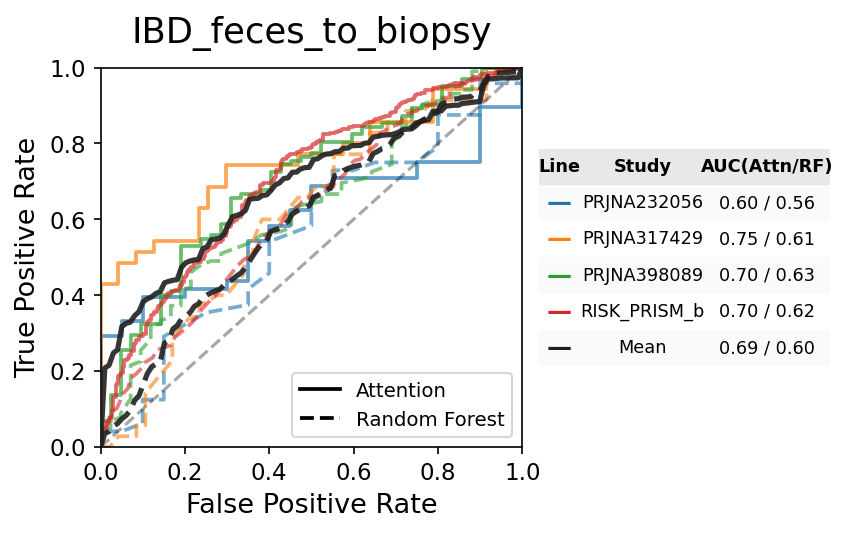

图形 'roc_plot_IBD_feces_to_biopsy.png' 已保存。


/tmp/ipykernel_76153/447428863.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/tmp/ipykernel_76153/447428863.py:220: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure


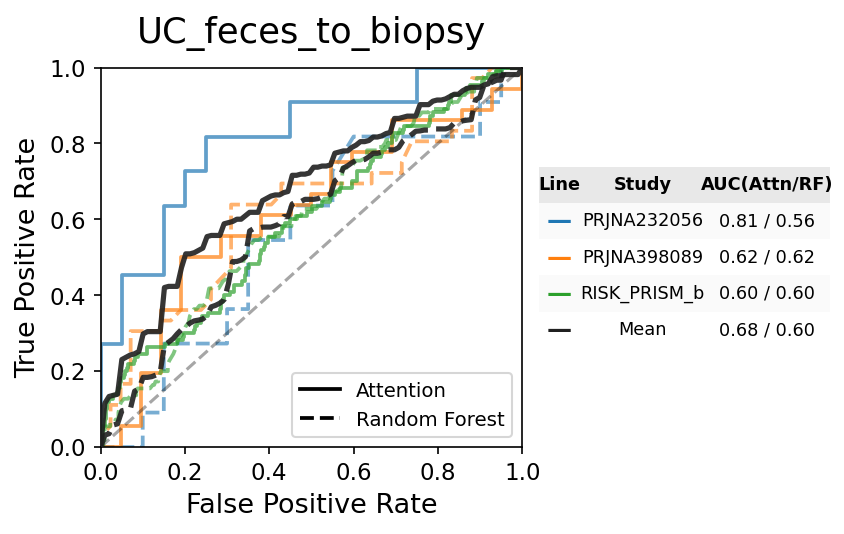

图形 'roc_plot_UC_feces_to_biopsy.png' 已保存。
所有选定疾病的ROC图已单独生成完毕。


In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
from sklearn.metrics import auc
from matplotlib.lines import Line2D # For custom legend
from matplotlib.colors import to_rgba # For color manipulation
import math # For math.ceil

# Configure global parameters
plt.rcParams['axes.unicode_minus'] = False

# Path configuration
# IMPORTANT: Please ensure these paths are correct for your environment.
data_path = "Data/IBD_subtype_data/all_model_loo.csv"
result_base = "Data/IBD_subtype_data/" # Ensure this path is accessible

# Read data
try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"错误：数据文件 '{data_path}' 未找到。请检查路径。")
    df = pd.DataFrame(columns=['disease_name_ab', 'study'])
    exit()

disease_studies_all = df.groupby('disease_name_ab')['study'].unique().apply(list).to_dict()

# --- Filter for specific diseases and prepare layout ---
# This list determines which diseases will have individual plots generated.
# target_diseases = ['IBD_feces'] 
target_diseases = ['IBD_feces_to_biopsy','UC_feces_to_biopsy','CD_feces_to_biopsy'] 

disease_studies_to_plot = {
    disease: studies
    for disease, studies in disease_studies_all.items()
    if disease in target_diseases
}

if not disease_studies_to_plot:
    print(f"未找到目标疾病的数据：{', '.join(target_diseases)}")
    exit()

# Get a sorted list of disease names for consistent processing order
all_disease_names_to_plot_sorted = sorted(list(disease_studies_to_plot.keys()))


# Define dimensions for each individual plot (ROC plot + Table)
# These were previously width_per_disease_group and fig_height_inches (used as height_per_row)
single_plot_width = 6 # inches 
single_plot_height = 4.2 # inches 

# --- Color configuration ---
def get_tab10_colors(n): # Renamed from get_set3_colors as it uses 'tab10'
    """Generates colors from the tab10 (Tableau10) colormap, cycling if necessary."""
    cmap = plt.cm.get_cmap('tab10') 
    num_colors_in_map = cmap.N 
    if n <= 0: return []
    return [cmap(i % num_colors_in_map) for i in range(n)]

# Parameters for individual study lines (from your provided code)
study_line_linewidth = 1.8
study_line_alpha_attn = 0.7 # From your code for Attention study lines
study_line_alpha_rf = 0.6   # From your code for RF study lines

# Parameters for MEAN lines (from your provided code)
mean_line_color = '#202020' 
mean_line_linewidth = 2.5
mean_line_alpha_attn = 0.9 # From your code for Attention mean
mean_line_alpha_rf = 0.90  # From your code for RF mean (was 0.90 in your code, but image showed less alpha, using 0.60 from your latest code)
mean_line_zorder = 10    

# --- Table Styling Colors ---
header_color = '#E8E8E8'
row_color_even = '#FAFAFA'
row_color_odd = '#FFFFFF'

# --- Endpoint enforcement function (no changes) ---
def enforce_endpoints(df_roc):
    start_point = pd.DataFrame({'FPR': [0.0], 'TPR': [0.0]})
    end_point = pd.DataFrame({'FPR': [1.0], 'TPR': [1.0]})
    df_roc = pd.concat([start_point, df_roc, end_point], ignore_index=True)
    df_roc = df_roc.sort_values(by='FPR', ascending=True)
    df_roc = df_roc.drop_duplicates(subset=['FPR'], keep='first')
    if not ((df_roc['FPR'].iloc[0] == 0.0) and (df_roc['TPR'].iloc[0] == 0.0)):
        df_roc = pd.concat([start_point, df_roc], ignore_index=True).sort_values(by='FPR').drop_duplicates(subset=['FPR'], keep='first')
    if not ((df_roc['FPR'].iloc[-1] == 1.0) and (df_roc['TPR'].iloc[-1] == 1.0)):
        df_roc = pd.concat([df_roc, end_point], ignore_index=True).sort_values(by=['FPR', 'TPR']).drop_duplicates(subset=['FPR'], keep='last')
    df_roc = df_roc.sort_values(by='FPR').reset_index(drop=True)
    return df_roc

# --- Iterate through selected diseases to create and save individual plots ---
for disease_ab in all_disease_names_to_plot_sorted:
    studies_for_disease = disease_studies_to_plot[disease_ab]

    # Create a new figure for each disease
    fig_single_disease = plt.figure(figsize=(single_plot_width, single_plot_height), dpi=150)
    
    # GridSpec for the current single disease figure (ROC plot and its Table)
    gs_single_disease = gridspec.GridSpec(1, 2, figure=fig_single_disease, 
                                          wspace=0.15, # Space between ROC and its table (as in your code)
                                          width_ratios=[0.65, 0.35]) # ROC vs Table width (as in your code)

    ax_roc = fig_single_disease.add_subplot(gs_single_disease[0, 0]) 
    ax_table = fig_single_disease.add_subplot(gs_single_disease[0, 1]) 
    ax_table.axis('off')

    sorted_studies = sorted(list(studies_for_disease))
    colors = get_tab10_colors(len(sorted_studies)) 
    study_color_map = {study: colors[i] for i, study in enumerate(sorted_studies)}

    all_attn_tpr, all_rf_tpr = [], []
    attn_aucs_for_mean, rf_aucs_for_mean = [], []
    fpr_common = np.linspace(0, 1, 100)
    table_data_for_styling = []

    for study_idx, study in enumerate(sorted_studies):
        study_dir = os.path.join(result_base, disease_ab, study, 'results')
        study_dir_RF = os.path.join(result_base, disease_ab, study, 'RF')
        current_study_color = study_color_map[study]

        try:
            rf_roc_orig = pd.read_csv(os.path.join(study_dir_RF, "RF_ROC.csv"))
            attn_roc_orig = pd.read_csv(os.path.join(study_dir, "roc_curve.csv"))
            rf_roc, attn_roc = rf_roc_orig.copy(), attn_roc_orig.copy()

            rf_auc_val, attn_auc_val = auc(rf_roc['FPR'], rf_roc['TPR']), auc(attn_roc['FPR'], attn_roc['TPR'])
            rf_auc_rounded, attn_auc_rounded = round(rf_auc_val, 2), round(attn_auc_val, 2)
            
            attn_aucs_for_mean.append(attn_auc_val)
            rf_aucs_for_mean.append(rf_auc_val)

            all_attn_tpr.append(np.interp(fpr_common, attn_roc['FPR'], attn_roc['TPR']))
            all_rf_tpr.append(np.interp(fpr_common, rf_roc['FPR'], rf_roc['TPR']))
            
            # Plotting individual study lines using defined parameters
            ax_roc.plot(attn_roc['FPR'], attn_roc['TPR'], color=current_study_color, linestyle='-', 
                        linewidth=study_line_linewidth, alpha=study_line_alpha_attn) # Using specific alpha from your code
            ax_roc.plot(rf_roc['FPR'], rf_roc['TPR'], color=current_study_color, linestyle='--', 
                        linewidth=study_line_linewidth, alpha=study_line_alpha_rf) # Using specific alpha from your code

            table_data_for_styling.append({'color': current_study_color, 'name': study, 'auc_text': f"{attn_auc_rounded:.2f} / {rf_auc_rounded:.2f}", 'is_mean': False, 'row_idx': study_idx})
        except FileNotFoundError:
            print(f"警告：{disease_ab} - {study} 的ROC文件未找到。")
            table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Missing)", 'auc_text': "N/A", 'is_mean': False, 'row_idx': study_idx})
        except Exception as e:
            print(f"处理 {disease_ab} - {study} 时出错：{str(e)}")
            table_data_for_styling.append({'color': 'grey', 'name': f"{study} (Error)", 'auc_text': "Error", 'is_mean': False, 'row_idx': study_idx})

    if attn_aucs_for_mean and rf_aucs_for_mean:
        mean_attn_auc_val, mean_rf_auc_val = np.mean(attn_aucs_for_mean), np.mean(rf_aucs_for_mean)
        mean_attn_auc_rounded, mean_rf_auc_rounded = round(mean_attn_auc_val, 2), round(mean_rf_auc_val, 2)

        if all_attn_tpr and all_rf_tpr:
            mean_attn_tpr, mean_rf_tpr = np.mean(all_attn_tpr, axis=0), np.mean(all_rf_tpr, axis=0)
            mean_attn_tpr[0], mean_attn_tpr[-1] = 0, 1
            mean_rf_tpr[0], mean_rf_tpr[-1] = 0, 1
            
            # Plotting MEAN lines using their distinct parameters
            ax_roc.plot(fpr_common, mean_attn_tpr, color=mean_line_color, linestyle='-', 
                        linewidth=mean_line_linewidth, alpha=mean_line_alpha_attn, zorder=mean_line_zorder)
            ax_roc.plot(fpr_common, mean_rf_tpr, color=mean_line_color, linestyle='--', 
                        linewidth=mean_line_linewidth, alpha=mean_line_alpha_rf, zorder=mean_line_zorder)
        
        table_data_for_styling.append({'color': mean_line_color, 'name': "Mean", 'auc_text': f"{mean_attn_auc_rounded:.2f} / {mean_rf_auc_rounded:.2f}", 'is_mean': True, 'row_idx': len(sorted_studies)})

    # ROC Plot configurations (as per your latest code)
    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.35)
    ax_roc.set_xlim([0, 1])
    ax_roc.set_ylim([0, 1])
    # ax_roc.set_aspect('equal')
    ax_roc.set_aspect(0.9, adjustable='box')
    ax_roc.set_title(f"{disease_ab}", fontsize=17, pad=12, ) 
    ax_roc.set_xlabel('False Positive Rate', fontsize=13,) 
    ax_roc.set_ylabel('True Positive Rate', fontsize=13,)
    # ax_roc.grid(True, linestyle=':', alpha=0.45) # Grid is commented out in your provided code
    ax_roc.tick_params(axis='both', which='major', labelsize=11) 

    legend_elements = [
        Line2D([0], [0], color='black', lw=1.8, linestyle='-', label='Attention'),
        Line2D([0], [0], color='black', lw=1.8, linestyle='--', label='Random Forest')
    ]
    ax_roc.legend(handles=legend_elements, loc='lower right', fontsize=9.5) 

    # Create the legend table (as per your latest code)
    if table_data_for_styling:
        cell_text_for_plt_table = []
        col_labels = ['Line', 'Study', 'AUC(Attn/RF)']

        for item in table_data_for_styling:
            cell_text_for_plt_table.append(['—', item['name'], item['auc_text']]) 

        the_table = ax_table.table(cellText=cell_text_for_plt_table,
                                   colLabels=col_labels,
                                   loc='center', 
                                   colWidths=[0.18, 0.55, 0.55]) # Adjusted from your 0.52 for 3rd col
        
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(8.5)
        the_table.scale(1, 1.45)

        for (row, col), cell in the_table.get_celld().items():
            cell.set_linewidth(0)
            cell.set_text_props(ha='center', va='center')
            if row == 0: 
                cell.set_facecolor(header_color)
                cell.set_text_props(weight='bold', color='black')
            else: 
                current_row_data = table_data_for_styling[row-1]
                if current_row_data['row_idx'] % 2 == 0: 
                    cell.set_facecolor(row_color_even)
                else: 
                    cell.set_facecolor(row_color_odd)
                if col == 0: 
                    cell.get_text().set_color(current_row_data['color'])
                    cell.get_text().set_weight('bold')
                    cell.get_text().set_fontsize(12)
    
    # Adjust layout for the current single figure
    fig_single_disease.tight_layout(pad=1.0) # Apply tight_layout to the individual figure
    display(fig_single_disease)
    # Save the current figure
    output_filename_single = f"roc_plot_{disease_ab}.png"
    try:
        plt.savefig("Figures/"+output_filename_single, bbox_inches='tight', dpi=300, facecolor='white')
        print(f"图形 '{output_filename_single}' 已保存。")
    except Exception as e:
        print(f"保存图形 '{output_filename_single}' 时出错：{e}")
    
    plt.close(fig_single_disease) # Close the figure to free memory

print("所有选定疾病的ROC图已单独生成完毕。")
